In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from tqdm import tqdm
#from oauth2client.client import GoogleCredentials
import numpy as np

from sklearn.preprocessing import MinMaxScaler
import os
from sklearn.model_selection import train_test_split

In [2]:
print(os.getcwd())

/Users/sbezawada/Documents/Workspace/MLE-COURSE/Capstone2/capstone_wakeword/models


In [3]:
DRIVE_FOLDER = '/Users/sbezawada/Documents/Workspace/MLE-COURSE/Capstone/Data/false/'
entries = [entry for entry in os.listdir(DRIVE_FOLDER) if os.path.isfile(os.path.join(DRIVE_FOLDER, entry))]
false_dict = {'name':[]}
for file in entries:

    false_dict['name'].append(file)
DRIVE_FOLDER = '/Users/sbezawada/Documents/Workspace/MLE-COURSE/Capstone/Data/true/'
entries = [entry for entry in os.listdir(DRIVE_FOLDER) if os.path.isfile(os.path.join(DRIVE_FOLDER, entry))]
true_dict = {'name':[]}
for file in entries:

    true_dict['name'].append(file)


In [4]:
df1 = pd.DataFrame(false_dict)
df1['label'] = 0
df1['path'] = '/Users/sbezawada/Documents/Workspace/MLE-COURSE/Capstone/Data/false/'

df2 = pd.DataFrame(true_dict)
df2['label'] = 1
df2['path'] = '/Users/sbezawada/Documents/Workspace/MLE-COURSE/Capstone/Data/true/'

# combine both dataframes
df = pd.concat([df1,df2])
#shuffle the labels
df = df.sample(frac=1, random_state=56).reset_index(drop=True)

print('The length of the dataset is: ', f'{df.shape[0]:,}')

labels = df['label'].unique()
df.head

The length of the dataset is:  1,567


<bound method NDFrame.head of                    name  label  \
0     Mani_false582.wav      0   
1           Mani350.wav      1   
2     Mani_false567.wav      0   
3     Mani_false854.wav      0   
4      Mani_false25.wav      0   
...                 ...    ...   
1562        Mani606.wav      1   
1563        Mani329.wav      1   
1564         Mani96.wav      1   
1565   Mani_false91.wav      0   
1566  Mani_false564.wav      0   

                                                   path  
0     /Users/sbezawada/Documents/Workspace/MLE-COURS...  
1     /Users/sbezawada/Documents/Workspace/MLE-COURS...  
2     /Users/sbezawada/Documents/Workspace/MLE-COURS...  
3     /Users/sbezawada/Documents/Workspace/MLE-COURS...  
4     /Users/sbezawada/Documents/Workspace/MLE-COURS...  
...                                                 ...  
1562  /Users/sbezawada/Documents/Workspace/MLE-COURS...  
1563  /Users/sbezawada/Documents/Workspace/MLE-COURS...  
1564  /Users/sbezawada/Documents/Worksp

In [5]:
#data check if new records made it in
df[df['name'] =='Mani_false881.wav']

,name,label,path
727,Mani_false881.wav,0,/Users/sbezawada/Documents/Workspace/MLE-COURS...


In [6]:
#extract for the complete dataset
def features_extractor(file):
    audio, sample_rate = librosa.load(file, res_type='kaiser_fast')
    #set a window width to 25 ms and the stride to 10 ms
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40,hop_length=int(0.010*sample_rate), n_fft=int(0.025*sample_rate))
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    return mfccs_scaled_features

In [7]:
extracted_features=[]
for i in range(len(df)):
    #print(i)
    file_name = df['path'][i] + df['name'][i] #os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=df['label'][i]
    #print(final_class_labels)
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

In [8]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-472.0259, 145.97658, 3.9457073, 36.730343, 1...",0
1,"[-360.56946, 146.80739, 17.688366, 42.45998, 5...",1
2,"[-511.9074, 104.88985, 16.42294, 9.589837, 7.8...",0
3,"[-487.00116, 108.75475, 38.73437, 38.12563, 17...",0
4,"[-666.19836, 55.971718, -25.079172, 51.797554,...",0


In [9]:
extracted_features_df['class'].value_counts()

0    791
1    776
Name: class, dtype: int64

In [10]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())
X.shape

(1567, 40)

In [11]:
### Train Test Split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
X_train.shape

(1253, 40)

In [12]:
y_train.sum()/len(y_train)

0.5075818036711891

In [13]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing import sequence
# fix random seed for reproducibility
tf.random.set_seed(7)

2022-11-20 11:07:16.797986: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.10.0


In [14]:
from tpot import TPOTClassifier
clf = TPOTClassifier(config_dict='TPOT NN', random_state=42,n_jobs=-1,
                     verbosity=2, population_size=10, generations=10)
clf.fit(X_train, y_train)

/Users/sbezawada/.virtualenvs/Capstone2/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


Optimization Progress:   0%|          | 0/110 [00:00<?, ?pipeline/s]

/Users/sbezawada/.virtualenvs/Capstone2/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/Users/sbezawada/.virtualenvs/Capstone2/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/Users/sbezawada/.virtualenvs/Capstone2/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")
/Users/sbezawada/.virtualenvs/Capstone2/lib/python3.9/site-packages/tpot/builtins/__init


Generation 1 - Current best internal CV score: 0.9800573705179282

Generation 2 - Current best internal CV score: 0.9800573705179282

Generation 3 - Current best internal CV score: 0.9800573705179282

Generation 4 - Current best internal CV score: 0.9800573705179282

Generation 5 - Current best internal CV score: 0.9800573705179282

Generation 6 - Current best internal CV score: 0.9800573705179282

Generation 7 - Current best internal CV score: 0.9800573705179282

Generation 8 - Current best internal CV score: 0.9800573705179282

Generation 9 - Current best internal CV score: 0.9800573705179282

Generation 10 - Current best internal CV score: 0.9880286852589641

Best pipeline: KNeighborsClassifier(StandardScaler(input_matrix), n_neighbors=3, p=1, weights=distance)


TPOTClassifier(config_dict='TPOT NN', generations=10, n_jobs=-1,
               population_size=10, random_state=42, verbosity=2)

In [15]:
clf.fitted_pipeline_

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=3, p=1, weights='distance'))])

In [16]:
clf.score(X_test, y_test)

/Users/sbezawada/.virtualenvs/Capstone2/lib/python3.9/site-packages/sklearn/metrics/_scorer.py:765: FutureWarning: sklearn.metrics.SCORERS is deprecated and will be removed in v1.3. Please use sklearn.metrics.get_scorer_names to get a list of available scorers and sklearn.metrics.get_metric to get scorer.
  warnings.warn(


0.9777070063694268

In [17]:
import shap
explainer = shap.Explainer(clf.predict, X_train)
shap_values = explainer(X_train)
shap_values.values

Permutation explainer: 1254it [36:54,  1.77s/it]                          


array([[ 0.0075    ,  0.00166667,  0.03166667, ...,  0.00833333,
         0.        ,  0.00833333],
       [ 0.        ,  0.00083333,  0.        , ..., -0.01333333,
        -0.0025    ,  0.0025    ],
       [-0.02916667, -0.00416667, -0.01      , ..., -0.00416667,
        -0.00916667,  0.00166667],
       ...,
       [-0.01916667,  0.00166667, -0.02916667, ...,  0.00083333,
        -0.00833333, -0.0375    ],
       [-0.02583333, -0.00833333, -0.00166667, ...,  0.00083333,
        -0.00083333, -0.00083333],
       [ 0.00166667,  0.00416667,  0.00916667, ...,  0.00166667,
         0.01583333,  0.0075    ]])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


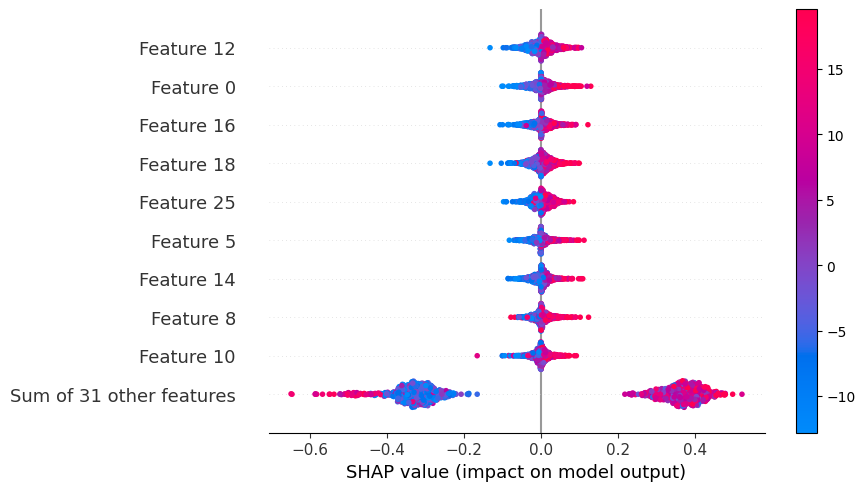

In [18]:
shap.plots.beeswarm(shap_values, show=False, color_bar=False)
#plt.gcf().axes[-1].set_box_aspect(2000)
plt.colorbar()
plt.show()

In [14]:
#v2 WITH 1 HIDDLEN LAYER

#X_train.shape #(1148, 40)

model = Sequential()
#model.add(Flatten())
model.add(Dense(12, input_dim =X_train.shape[1],activation=tf.nn.relu))
#output layer
model.add(Dense(1, activation=tf.nn.sigmoid))
model.compile(loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],optimizer='adam')
model.fit(X_train, y_train, epochs=5, batch_size=500)

2022-11-20 11:07:35.285470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/5
3/3 [==============================] - 1s 2ms/step - loss: 52.3356 - accuracy: 0.4924 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 2/5
3/3 [==============================] - 0s 2ms/step - loss: 49.6146 - accuracy: 0.4924 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 3/5
3/3 [==============================] - 0s 2ms/step - loss: 46.9382 - accuracy: 0.4924 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/5
3/3 [==============================] - 0s 2ms/step - loss: 44.2682 - accuracy: 0.4924 - precision: 0.0000e+00 - recall: 0.0000e+00

In [15]:
test_loss, test_accuracy,test_precision, test_recall  = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_accuracy)
print('Test precision:', test_precision)
print('Test Recall:', test_recall)

10/10 [==============================] - 0s 1ms/step - loss: 34.6352 - accuracy: 0.5541 - precision: 0.0000e+00 - recall: 0.0000e+00
Test Accuracy: 0.5541401505470276
Test precision: 0.0
Test Recall: 0.0


In [16]:
#v3 WITH 2 HIDDLEN LAYERS

#X_train.shape #(1148, 40)

model = Sequential()
#model.add(Flatten())
model.add(Dense(100, input_dim =X_train.shape[1],activation=tf.nn.relu))
model.add(Dense(200,activation=tf.nn.relu))
#output layer
model.add(Dense(1, activation=tf.nn.sigmoid))
model.compile(loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],optimizer='adam')
model.fit(X_train, y_train, epochs=9, batch_size=500)

Epoch 1/9
3/3 [==============================] - 1s 3ms/step - loss: 3.7751 - accuracy: 0.5499 - precision_1: 0.6065 - recall_1: 0.3223
Epoch 2/9
3/3 [==============================] - 0s 3ms/step - loss: 1.9559 - accuracy: 0.6824 - precision_1: 0.6169 - recall_1: 0.9874
Epoch 3/9
3/3 [==============================] - 0s 4ms/step - loss: 0.9034 - accuracy: 0.7765 - precision_1: 0.9140 - recall_1: 0.6179
Epoch 4/9
3/3 [==============================] - 0s 9ms/step - loss: 0.6664 - accuracy: 0.8268 - precision_1: 0.9182 - recall_1: 0.7233

In [17]:
test_loss, test_accuracy,test_precision, test_recall  = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_accuracy)
print('Test precision:', test_precision)
print('Test Recall:', test_recall)

10/10 [==============================] - 0s 1ms/step - loss: 0.6028 - accuracy: 0.9140 - precision_1: 0.8466 - recall_1: 0.9857
Test Accuracy: 0.9140127301216125
Test precision: 0.8466257452964783
Test Recall: 0.9857142567634583


In [18]:
#v4 WITH 3 HIDDLEN LAYERS & DROPOUT

#X_train.shape #(1148, 40)

model = Sequential()
#model.add(Flatten())
model.add(Dense(100, input_dim =X_train.shape[1],activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(200,activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(100,activation=tf.nn.relu))
model.add(Dropout(0.2))
#output layer
model.add(Dense(1, activation=tf.nn.sigmoid))
model.compile(loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],optimizer='adam')
model.fit(X_train, y_train, epochs=10, batch_size=500)

Epoch 1/10
3/3 [==============================] - 1s 4ms/step - loss: 12.2454 - accuracy: 0.5219 - precision_2: 0.5388 - recall_2: 0.4041
Epoch 2/10
3/3 [==============================] - 0s 4ms/step - loss: 7.8518 - accuracy: 0.5994 - precision_2: 0.5991 - recall_2: 0.6368
Epoch 3/10
3/3 [==============================] - 0s 3ms/step - loss: 5.4153 - accuracy: 0.6792 - precision_2: 0.7003 - recall_2: 0.6431
Epoch 4/10
3/3 [==============================] - 0s 3ms/step - loss: 4.1740 - accuracy: 0.7263 - precision_2: 0.8220 - recall_2: 0.5881

In [19]:
test_loss, test_accuracy,test_precision, test_recall  = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_accuracy)
print('Test precision:', test_precision)
print('Test Recall:', test_recall)

10/10 [==============================] - 0s 1ms/step - loss: 0.6040 - accuracy: 0.9268 - precision_2: 0.8774 - recall_2: 0.9714
Test Accuracy: 0.9267516136169434
Test precision: 0.8774193525314331
Test Recall: 0.9714285731315613


Epoch 1/3
28/28 [==============================] - 1s 9ms/step - loss: 1.5119 - accuracy: 0.7993 - precision_3: 0.8205 - recall_3: 0.7805 - val_loss: 0.4554 - val_accuracy: 0.9149 - val_precision_3: 0.8768 - val_recall_3: 0.9622
Epoch 2/3
28/28 [==============================] - 0s 2ms/step - loss: 0.3766 - accuracy: 0.9065 - precision_3: 0.9109 - recall_3: 0.9069 - val_loss: 0.3399 - val_accuracy: 0.9176 - val_precision_3: 0.8702 - val_recall_3: 0.9784
Epoch 2: early stopping
10/10 [==============================] - 0s 1ms/step - loss: 0.3218 - accuracy: 0.9204 - precision_3: 0.8662 - recall_3: 0.9714
Test Accuracy: 0.9203821420669556
Test precision: 0.8662420511245728
Test Recall: 0.9714285731315613


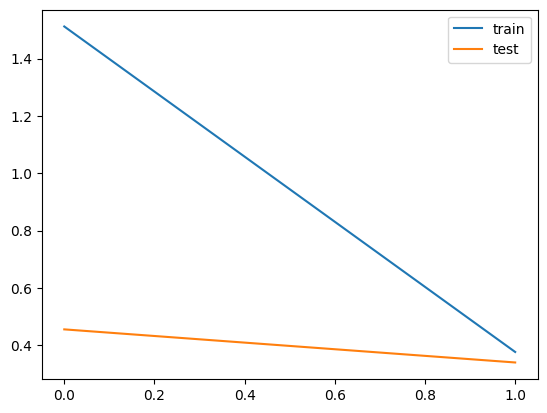

In [20]:
#how does accuracy change when early stopping is involved?
from tensorflow.keras.callbacks import EarlyStopping
model = Sequential()
model.add(Dense(100, input_dim =X_train.shape[1],activation=tf.nn.relu))
model.add(Dense(200,activation=tf.nn.relu))
model.add(Dense(100,activation=tf.nn.relu))
#output layer
model.add(Dense(1, activation=tf.nn.sigmoid))
model.compile(loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],optimizer='adam')
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, validation_split=0.3,epochs=3, callbacks=[es])

test_loss, test_accuracy,test_precision, test_recall  = model.evaluate(X_test, y_test)
print('Test Accuracy:', test_accuracy)
print('Test precision:', test_precision)
print('Test Recall:', test_recall)

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Options to discuss:
1. reduce MFCC from 40 to 20?

In [22]:
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_train2.shape

(1253, 1, 40)

In [23]:
batch_size =500
#vanilla LSTM
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units=60,return_sequences=True,input_shape=(X_train2.shape[1], X_train2.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(200,activation=tf.nn.relu))
model.add(Dense(1, activation=tf.nn.sigmoid))
model.compile(loss='binary_crossentropy',metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],optimizer='adam')
history = model.fit(X_train2,y_train.reshape((-1,1)),epochs=50,batch_size=batch_size,verbose=0,validation_split=0.25)


In [24]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 60)             24240     
                                                                 
 dropout_3 (Dropout)         (None, 1, 60)             0         
                                                                 
 dense_13 (Dense)            (None, 1, 200)            12200     
                                                                 
 dense_14 (Dense)            (None, 1, 1)              201       
                                                                 
Total params: 36,641
Trainable params: 36,641
Non-trainable params: 0
_________________________________________________________________


In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'precision_4', 'recall_4', 'val_loss', 'val_accuracy', 'val_precision_4', 'val_recall_4'])

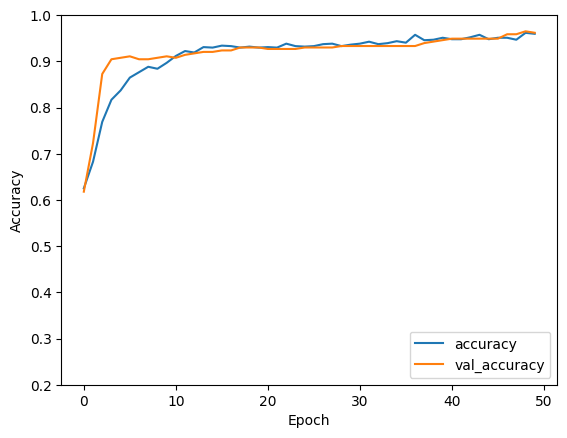

In [26]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')

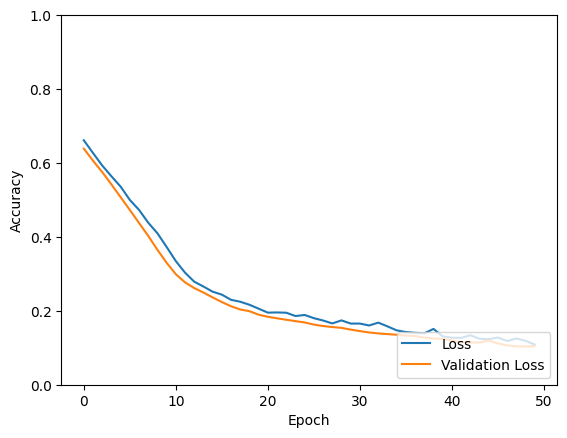

In [27]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')


In [29]:
y_pred = model.predict( X_test.reshape(X_test.shape[0], 1, X_test.shape[1]), batch_size = batch_size, verbose=1)
y_pred = (y_pred > 0.5).astype('int')

from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

accuracy = accuracy_score(y_test, y_pred.ravel())
print("Accuracy Score is : " + "{:.2%}".format(accuracy))
print(' ')
cm = confusion_matrix(y_test, y_pred.ravel(), labels=[0, 1])

1/1 [==============================] - 3s 3s/step
Accuracy Score is : 93.63%
 


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94       174
           1       0.88      0.99      0.93       140

    accuracy                           0.94       314
   macro avg       0.94      0.94      0.94       314
weighted avg       0.94      0.94      0.94       314

 


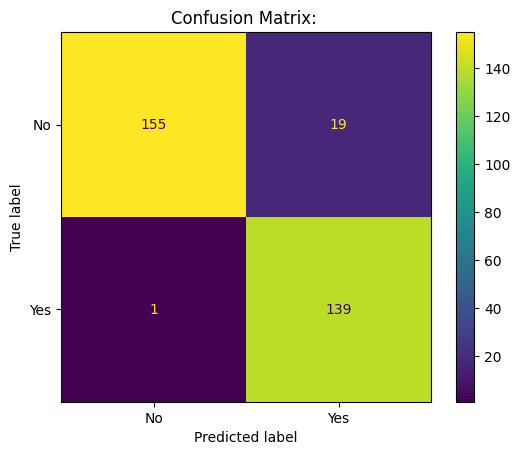

In [30]:
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])

disp.plot()
plt.title('Confusion Matrix: ')

print("Classification Report:")
print(classification_report(y_test, y_pred.ravel(), labels=[0, 1], zero_division=1))
print(" ")
plt.show()

In [31]:
import joblib
filename='LSTM_Spotify.sav'
joblib.dump(model, filename)


INFO:tensorflow:Assets written to: ram://4582c0df-febc-449a-a443-fc7b6a36a883/assets


INFO:tensorflow:Assets written to: ram://4582c0df-febc-449a-a443-fc7b6a36a883/assets


['LSTM_Spotify.sav']

In [28]:
model.save("LSTM_Spotify")

INFO:tensorflow:Assets written to: LSTM_Spotify/assets


INFO:tensorflow:Assets written to: LSTM_Spotify/assets
